# 104.X. Image cutouts with the Butler

<div style="max-width:300px; float: left; margin-right: 1em">

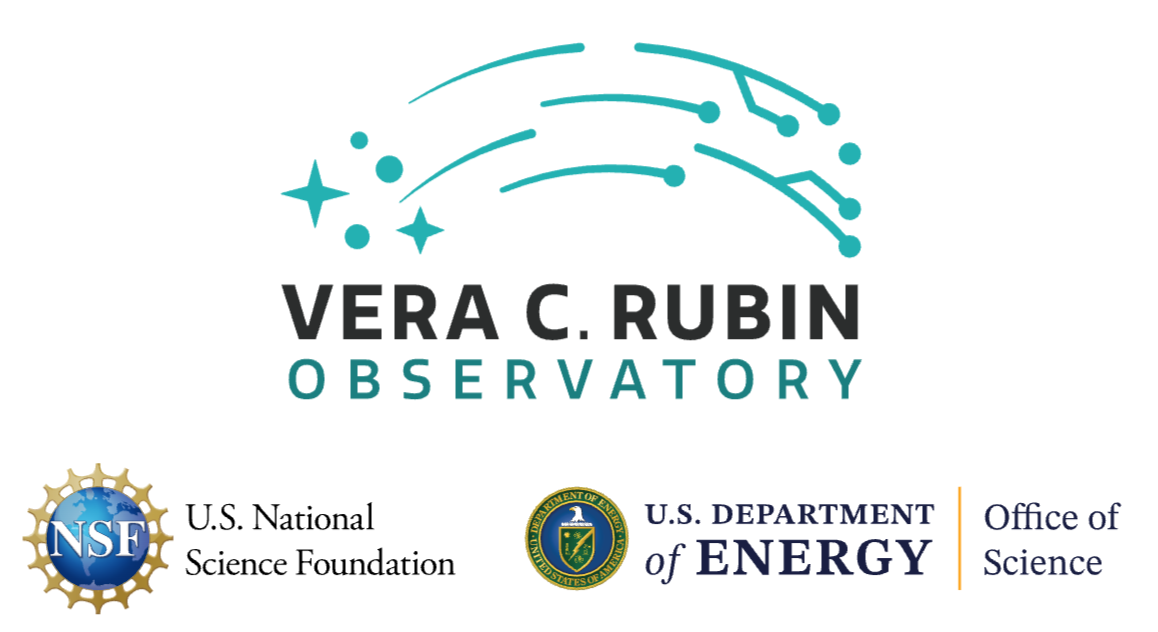

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-02 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** How to query and retrieve image data with the Butler.

**LSST data products:** `visit_image`, `deep_coadd`

**Packages:** `lsst.daf.butler`

**Credit:** Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

The Butler is LSST Science Pipelines middleware for managing, reading, and writing datasets.

As the interface between the pipelines and the data, it is often referred to as "middleware".

Butler-related documentation:
* [pipelines middleware Frequently Asked Questions](https://pipelines.lsst.io/middleware/index.html)
* [Butler python module documentation](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html)
* [Butler query expressions and operators](https://pipelines.lsst.io/modules/lsst.daf.butler/queries.html#datasettype-expressions)

**This tutorial** demonstrates the individual components of Butler queries and how to compose expressions using the allowed operators.

**Related tutorials:** The earlier 100-level Butler tutorials in this series show how to retrieve data with the Butler and how to explore and discover the dataset types and their properties.

### 1.1. Import packages

Import the `butler` module from the `lsst.daf` package, and the `display` module from the `lsst.afw` package (for image display).


In [ ]:
from lsst.daf.butler import Butler, Timespan
import lsst.afw.display as afw_display
import lsst.sphgeom as sphgeom
import lsst.geom as geom

from lsst.afw.image import LOCAL # this is needed to access origin=0 options
# stuff i am adding
from lsst.geom import Box2I, Point2I, Extent2I
import sys

import lsst.afw.image as afw_image
import matplotlib.pyplot as plt

### 1.2. Define parameters

Create an instance of the Butler with the repository and collection for DP1, and assert that it exists.

In [ ]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

Set `afwDisplay` to use matplotlib.

In [ ]:
afw_display.setDefaultBackend('matplotlib')


**Coordinates:**
Use coordinates RA, Dec = $53.076, -28.110$ deg, which are near the center of the Extended Chandra Deep Field South (ECDFS).

**Region:** Define a circle with a radius of 0.1 deg, centered on the coordinates.

In [ ]:
hudf_ra = 53.159
hudf_dec = -27.7815854

ra = hudf_ra
dec = hudf_dec

radius = 0.1
region = sphgeom.Region.from_ivoa_pos(f"CIRCLE {ra} {dec} {radius}")

## 2. The bbox

Define the `bbox` region for a cutout that is centered on pixel coordinate x,y and is XX pixels wide and XX pixels high.




maybe the tutorial can incorporate a few of the bbox demos on https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html also.

In [ ]:

dataset_refs = butler.query_datasets("deep_coadd",
                                     where="patch.region OVERLAPS region AND band='r'",
                                     bind={"region": region},
                                     with_dimension_records=True,
                                     order_by=["patch.tract"])

#radec = geom.SpherePoint(ra, dec, geom.degrees)

In [ ]:
# get the data Id
dataset_refs = butler.query_datasets("deep_coadd",
                                                 where="band.name='r' AND\
                                                patch.region OVERLAPS POINT(ra, dec)",
                                                 bind={"ra": hudf_ra, "dec": hudf_dec},
                                                 with_dimension_records=True,
                                                 order_by=["patch.tract"])

coadd = butler.get(dataset_refs[0],imageOrigin='LOCAL')
dataId = dataset_refs[0].dataId

bbox = coadd.getBBox(LOCAL) #origin=ImageOrigin.PARENT)
print("x pixel values range between", bbox.beginX, bbox.endX)
print("y pixel values range between", bbox.beginY, bbox.endY)


In [ ]:
wcs = butler.get("deep_coadd.wcs", dataId=dataId)
print(wcs)


### 2.1.1 Use BBox parameters for cutout

In [ ]:

bbox = coadd.getBBox()#origin=ImageOrigin.PARENT)
print("x pixel values range between", bbox.beginX, bbox.endX)
print("y pixel values range between", bbox.beginY, bbox.endY)

print(coadd.getXY0())

#print(bbox.getDimensions())
#print(bbox.getMin())
#print(bbox.getMax())

In [ ]:
cutout_xctr = bbox.beginX + (bbox.endX - bbox.beginX)/2
cutout_yctr = bbox.beginY + (bbox.endY - bbox.beginY)/2

cutout_pixsize = 500

cutout_xmin = cutout_xctr - cutout_pixsize / 2
cutout_ymin = cutout_yctr - cutout_pixsize / 2
cutout_xmax = cutout_xctr + cutout_pixsize / 2
cutout_ymax = cutout_yctr + cutout_pixsize / 2


In [ ]:
box2 = Box2I(minimum=Point2I(x=cutout_xmin, y=cutout_ymin), maximum=Point2I(x=cutout_xmax, y=cutout_ymax))


In [ ]:
# its also possible to do this:
#img_cutout = img[cutout_xmin:cutout_xmax, cutout_ymin:cutout_ymax]

### 2.1.2 Use Extent2I 



An alternative statement to create `bbox` is:
```
bbox = geom.Box2I(geom.Point2I(xmin, ymin), geom.Extent2I(w, h))
```


### 2.2 Pass bbox to the Butler

#### 2.2.1 Use pixel coordinates

In [ ]:
parameters = {'bbox': box2}
cutout_image = butler.get('deep_coadd', parameters=parameters, dataId=dataId)

cutout_image.getBBox?

In [ ]:
fig, ax = plt.subplots()
display = afw_display.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
plt.show()

#### 2.2.2 Use sky coordinates

The following cell demonstrates how to define cutouts using 

In [ ]:

radec_hudf = geom.SpherePoint(hudf_ra, hudf_dec, geom.degrees)
xy_hudf = geom.PointI(wcs.skyToPixel(radec_hudf))

cutoutSize = geom.ExtentI(500, 500) # this needs to be updated to be an angular definition




In [ ]:

bbox = geom.Box2I()
bbox.include(geom.Point2I(xy_hudf - cutoutSize/2))
bbox.include(geom.Point2I(xy_hudf + cutoutSize/2))



In [ ]:
parameters = {'bbox': bbox}
cutout_image = butler.get('deep_coadd', parameters=parameters, dataId=dataId)



In [ ]:

fig, ax = plt.subplots()
display = afw_display.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
plt.show()

## 3. The subset method

Use case: When the user already has the full image from the butler and wants to make one or more cutouts from it. Use subset for that (do NOT use getCutout, or Factory, or ImageCutoutFactory)

lsst.afw.image.ExposureF.subset = subset(...)
    subset(self: lsst.afw.image._exposure.ExposureF, bbox: lsst.geom.Box2I, origin: lsst.afw.image._image.ImageOrigin = <ImageOrigin.PARENT: 0>) -> lsst.afw.image._exposure.ExposureF







Re multiple bboxes: no, you should butler.get the whole image once and then do the cutouts yourself (there is an easy Exposure api for that -- subset maybe)

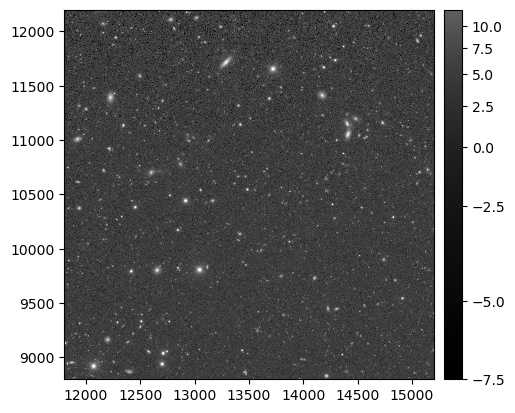

In [18]:
big_image = butler.get('deep_coadd', dataId=dataId)

fig, ax = plt.subplots()
display = afw_display.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(big_image.image)
plt.show()



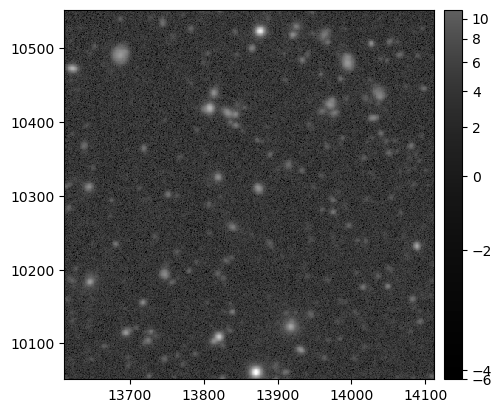

In [19]:
big_image_cutout = big_image.subset(bbox)
fig, ax = plt.subplots()
display = afw_display.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(big_image_cutout.image)
plt.show()




In [20]:
sys.exit()

SystemExit: 

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#band = 'r'

#dataId = {"band": band, "patch": patch, "tract": tract}

## 3. The factory method (maybe don't do this


NOTE: this is verbatim from 105.2 section 2.6

There are several ways to create image cutouts. This tutorial demonstrates the use of the `Factory` method for a `visit_image`.

The arguments that must be passed to the `Factory` method are:
```
visit_image : the image to make the cutout from
bbox   : the desired bounding box of the cutout
origin : the image pixel origin, local to the cutout array
deep   : if True, copy the data rather than passing by reference
```


Generate the cutout.

In [ ]:

print(dataId)


image = butler.get('deep_coadd', dataId=dataId)
cutout = image.Factory(image, bbox)#, origin=afw_image.LOCAL, deep=False)


In [ ]:

plt.imshow(cutout.image.array, origin='lower', cmap='gray',
           vmin=0.1, vmax=500, norm='asinh')



https://pipelines.lsst.io/py-api/lsst.dax.images.cutout.ImageCutoutFactory.html

dax_images_cutout (which is the package with ImageCutoutFactory that the cutout system uses). Doing multiple cutouts from a single image is better done by doing a butler.get once and then extracting subsets from it.

this is not meant to be a public API so don't show this.

In [ ]:

image.Factory?

In [ ]:
import lsst.dax.images.cutout as ct

In [ ]:
ct.ImageCutoutFactory?

Notes: look at tutorial 105.2 because it uses visit.Factory. First use case is the one that is in cutout_coadd and and the second use case is to use/apply Factory to it after you have retrieved the image.

if you can find more documentation on this factory thing, maybe it can make other things? 

To include from the jira ticket:

A how-to for making image cutouts with the butler.

Show retrieving a cutout only by passing a Box2I.

Show retrieving the full image and making multiple cutouts with the Factory function.

Can you pass it a list of centers to plot many cutouts?

Check this slack thread for updates: https://rubin-obs.slack.com/archives/C07QFRSKE2Z/p1759955584983999

Also test out:
image.getCutout?
this appears to be a butler method.

Make a quick draft showing how to make multiple cutouts. then pass to jim and ask is this waht you want people to know / process you want people to follow? (maybe not jim or Tim look at it on slack? OR a middlare slack channel? if it takes 1 month, perhaps Melissa can take it to the middleware meeting instead in 4 weeks. dm_middleware_support

For bulk cutouts (different but keep in mind)
https://dmtn-326.lsst.io/v/DM-52674/index.html

Keep tabs on thread about using .subset:
https://rubin-obs.slack.com/archives/C08CANY4B6H/p1762386607860949

junk code:

In [ ]:
parameters = {'bbox': bbox}


query = """band.name = '{}' AND patch = {} AND tract = {}
        """.format('i', patch, tract)
print(query)

dataset_refs = butler.query_datasets("deep_coadd", where=query)

#query = """band.name = '{}' AND patch = {} AND tract = {}
#    """.format('i', patch, tract)
#print(query)

    #dataset_refs = butler.query_datasets("deep_coadd", where=query)

#cutout_image = butler.get(dataId, parameters=parameters)
cutout_image = butler.get('deep_coadd', dataId=dataId, parameters=parameters)

In [ ]:
cutoutSideLength=5
cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
import numpy as np
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)
xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
print(xy)
xy?
#xy = (1200, 1200)
#print(xy)
#bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
##print("bbox = ", bbox, "xy = ", xy, "cutoutSize = ", cutoutSize)
#print(xy)
#patch = tractInfo.getSequentialPatchIndex(patchInfo)
#tract = tractInfo.getId()
#geom.PointI?

In [ ]:
#point = geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)
#radec = point
#skymap = butler.get("skyMap", skymap="lsst_cells_v1")
#tract = skymap.findTract(point).tract_id
#patch = skymap.findTract(point).findPatch(point).getSequentialIndex()
#xy = tract.getCtrCoord()
#print(tract, patch)

In [ ]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    print("bbox = ", bbox, "xy = ", xy, "cutoutSize = ", cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)
    tract = tractInfo.getId()

    parameters = {'bbox': bbox}

    query = """band.name = '{}' AND patch = {} AND tract = {}
        """.format('i', patch, tract)
    print(query)

    dataset_refs = butler.query_datasets("deep_coadd", where=query)

    cutout_image = butler.get(dataset_refs[0], parameters=parameters)

    return cutout_image

In [ ]:
# Define the bounding box for the desired cutout
imageBbox = geom.Box2I(corner=geom.Point2I(16800, 18600), dimensions=geom.Extent2I(800, 800))

# Use the Butler to get the image cutout, passing the bbox as a parameter
calexp = butler.get('deepCoadd_calexp', dataId=dataId, parameters={'bbox': imageBbox})
